In [1]:
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore")

Get Technical Features

In [2]:
sp1500 = pd.read_excel("../data/SPR as of Feb 12 20251.xlsx")
tickers = sp1500['Ticker'].str.split(" ").str[0]

In [3]:
import sys
import os

# Get the absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Get the parent directory of the current working directory

# Construct the path to the `src` directory
src_path = os.path.join(project_root, "src")

# Add the `src` directory to the Python module search path
sys.path.append(src_path)


In [4]:
import importlib
from Features import technical_features_new

importlib.reload(technical_features_new)
from Features.technical_features_new import BuildFeatures

In [5]:
# Generate all NYSE trading days from 1980 to 2025
all_dates = pd.bdate_range(start="1980-01-01", end="2025-02-24", freq="B") 
date_to_qid = {date: qid for qid, date in enumerate(all_dates)}

In [29]:
import pickle as pkl
import gzip
from tqdm import tqdm

# Define storage path
cache_path = "../data/technical_features"

# Ensure the directory exists
os.makedirs(cache_path, exist_ok=True)

# Process stock data
for tick in tqdm(tickers, desc="Processing Tickers", unit="ticker"):
    try:
        obj = BuildFeatures(tick)
    except:
        continue
    
    obj.build_technical_features()  # Compute technical indicators
    data = obj.technical_features.copy()
        
    if data.empty:
        continue
    
    data["Close"] = obj.stock["Adj Close"]
    data = data.resample('BM').last()
    data["Return"] = data["Close"].pct_change().shift(-1).astype(np.float32)

    # Define file path
    file_path = os.path.join(cache_path, f"{tick}.pkl.gz")

    # Save the data using gzip compression to reduce file size
    with gzip.open(file_path, "wb") as f:
        pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)

print("✅ All data has been successfully stored and optimized with compression!")


Processing Tickers: 100%|██████████| 1506/1506 [21:46<00:00,  1.15ticker/s]

✅ All data has been successfully stored and optimized with compression!


In [6]:
import importlib
from Features import fundamental_features_new

importlib.reload(fundamental_features_new)
from Features.fundamental_features_new import BuildFeatures as BuildFundamentalFeatures

In [7]:
zacks_fc = pd.read_csv("../data/fundamental_data/ZACKS_FC.csv", delimiter=',')
zacks_fc['per_end_date'] = pd.to_datetime(zacks_fc['per_end_date'])
zacks_fc['per_end_date'] = zacks_fc['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fc = zacks_fc.sort_values('per_end_date').set_index('per_end_date')

zacks_fr = pd.read_csv("../data/fundamental_data/ZACKS_FR.csv", delimiter=',')
zacks_fr['per_end_date'] = pd.to_datetime(zacks_fr['per_end_date'])
zacks_fr['per_end_date'] = zacks_fr['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fr = zacks_fr.sort_values('per_end_date').set_index('per_end_date')

zack_data = {}
zack_data["zacks_fc"] = zacks_fc
zack_data["zacks_fr"] = zacks_fr


In [8]:
from tqdm import tqdm
import pickle as pkl
import gzip

# Define storage path
cache_path = "../data/fundamental_features"

# Ensure the directory exists
os.makedirs(cache_path, exist_ok=True)

for tick in tqdm(tickers, desc="Processing Tickers", unit="ticker"):

    try:
        obj = BuildFundamentalFeatures(zack_data, tick)
    except:
        continue

    obj.process_financial_statements()  # Generate technical features for the ticker
    
    # Merge technical features with the calculated returns
    data = obj.fundamental_features.copy()
    
    if data.empty:
        continue

    data = data[data['per_type'] == 'Q']
    data['filing_date'] = pd.to_datetime(data['filing_date'])
    data.index.name = 'report_date'
    data = data.reset_index()
    
    data = data.set_index('filing_date')
    data['filing_date'] = data.index
    try:
        full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq="D")
    except:
        continue
    
    data = data.drop_duplicates(subset="filing_date", keep="last")
    data = data.reindex(full_date_range)
    data = data.ffill().resample('BM').last()
    
    data["Close"] = obj.stock['Adj Close']
    
    data["Return"] = data["Close"].pct_change().shift(-1)
    
    # Define file path
    file_path = os.path.join(cache_path, f"{tick}.pkl.gz")

    # Save the data using gzip compression to reduce file size
    with gzip.open(file_path, "wb") as f:
        pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)

print("✅ All data has been successfully stored and optimized with compression!")

Processing Tickers:  10%|█         | 151/1506 [01:48<21:54,  1.03ticker/s]

In [53]:
from tqdm import tqdm
import gzip
import pickle as pkl
import numpy as np
import pandas as pd
import os

# Set cutoff dates for training, validation, and test sets
train_cutoff = "2014-01-01"
valid_cutoff = "2018-01-01"

# Paths
data_path_tech = "../data/technical_features"
data_path_fin = "../data/fundamental_features"

# List to store all data
all_data = []

# Process all tickers
for tick in tqdm(tickers, desc="Processing Tickers", unit="ticker"):
    file_path_tech = os.path.join(data_path_tech, f"{tick}.pkl.gz")
    file_path_fin = os.path.join(data_path_fin, f"{tick}.pkl.gz")
    try:
        # Load technical data
        with gzip.open(file_path_tech, "rb") as f:
            tech_data = pkl.load(f)
            tech_data["Ticker"] = tick

        # Load fundamental data
        with gzip.open(file_path_fin, "rb") as f:
            fin_data = pkl.load(f)
            fin_data = fin_data.dropna(axis=1, how="all")
            fin_data = fin_data.select_dtypes(include=[float, int])  # Keep only numeric columns

        combined_data = tech_data.merge(fin_data, how="outer", left_index=True, right_index=True)
        combined_data['Return'] = combined_data['Return_x'].fillna(combined_data['Return_y'])
        combined_data = combined_data.drop(columns=['Return_x', 'Return_y'])
        combined_data = combined_data.dropna(subset=['Return'])
        combined_data = combined_data.ffill()
        combined_data.index.name = 'date'
    except:
        continue

    all_data.append(combined_data)

# Merge all data and sort by date
all_data_df = pd.concat(all_data).sort_index()
all_data_df = all_data_df.dropna(subset=["Return"])

# Define threshold for missing values
threshold = len(all_data_df) * 0.3
all_data_df = all_data_df.dropna(axis=1, thresh=threshold)
all_data_df = all_data_df.dropna()

# Assign qid values based on unique dates
unique_dates = all_data_df.index.unique()
date_to_qid = {date: i for i, date in enumerate(unique_dates)}
all_data_df["qid"] = all_data_df.index.map(date_to_qid).astype(np.int32)

# Compute quintile ranking for stock returns
def compute_ranked_labels(df):
    df["Ranked_Return"] = df.groupby("qid")["Return"].transform(
        lambda x: pd.qcut(x, 5, labels=False, duplicates="drop")  # 0-4 ranking
    ).astype(np.int32)
    return df

all_data_df = compute_ranked_labels(all_data_df)


Processing Tickers: 100%|██████████| 1506/1506 [00:07<00:00, 206.17ticker/s]


In [31]:
all_data_df

,SMA_50,SMA_200,Chaikin_ADI_Line,Chaikin_ADI_Oscillator,ADM_Index,ADM_Index_Rating,Absolute_Price_Oscillator,Average_True_Range,Average_Price,Bollinger_Band_Upper,...,ret_tang_equity,ret_asset,ret_invst,free_cash_flow_per_share,book_val_per_share,oper_cash_flow_per_share,Return,invty_turn,qid,Ranked_Return
date,,,,,,,,,,,,,,,,,,,,,
2006-02-28,15.33200000,13.89725000,19787055.45225894,91098.62506811,25.35514525,36.79358752,-0.05583333,0.47791313,16.03000000,16.27547308,...,2.41990000,1.00750000,1.41570000,0.77180000,9.88180000,1.00040000,0.06582614,1.34770000,0,4
2006-02-28,71.97160000,67.03685000,438409553.58438098,4785522.14336479,24.49164491,28.19244280,1.74865385,1.51875810,76.54250000,79.25579046,...,3.89010000,0.67730000,1.17340000,-2.20820000,14.66320000,-2.01870000,0.04159702,1.06030000,0,2
2006-02-28,19.20660200,17.81895050,1069356673.00502253,-23599627.24155426,15.68530035,15.76167221,0.05910256,0.55219325,18.37000000,19.47512271,...,1.73280000,1.27370000,1.57330000,0.23030000,5.46310000,0.26070000,-0.04421966,0.99680000,0,0
2006-03-31,37.83920000,35.02880000,52129545.81676864,-124193.04109319,17.24029386,18.14339384,0.67955128,0.76992648,39.64500000,39.86100690,...,20.92850000,4.54880000,9.06830000,0.17430000,4.12520000,1.56060000,0.06251384,1.10460000,1,4
2006-03-31,16.14300000,14.21190000,21109761.37547952,286410.03960658,16.31936042,18.36062973,0.40685897,0.44840756,16.99000000,17.35194117,...,2.41990000,1.00750000,1.41570000,0.77180000,9.88180000,1.00040000,-0.09881708,1.34770000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,45.52800000,44.53505000,87479962.49501921,-101846.88133305,25.31813728,28.63369877,-0.50564103,1.03563897,40.97500000,42.32410038,...,-4.27960000,1.55080000,2.37110000,-2.37280000,13.97870000,-1.71360000,-0.03542634,3.94790000,227,2
2025-01-31,47.41760000,45.89090000,62695076.41965339,-213837.52942304,15.03374942,15.39448075,-0.96775641,1.51045696,44.61250000,45.05194233,...,1.46160000,0.97710000,1.28360000,0.26820000,17.52900000,0.55810000,-0.05997745,0.52700000,227,1
2025-01-31,50.16020000,51.77480000,87162454.71050200,-722874.65171105,44.12077502,34.60314479,3.10583333,1.50319060,56.67500000,56.79621978,...,-35.70690000,6.46880000,7.00160000,4.64560000,3.55950000,2.30990000,0.01959746,0.37610000,227,3


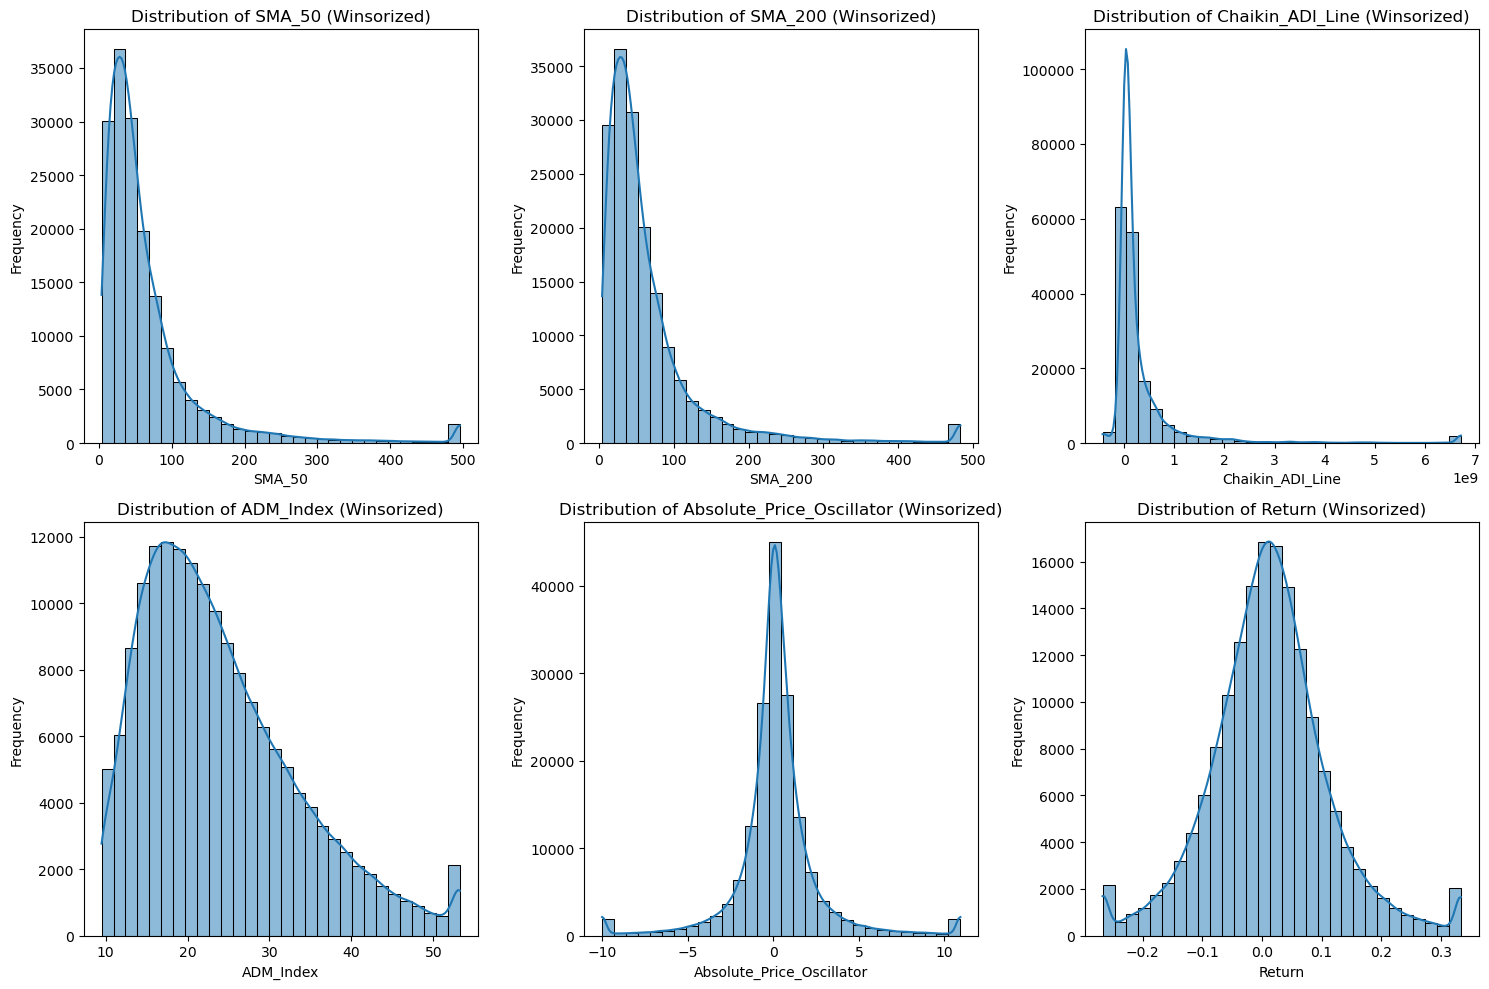

In [39]:
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns 

# Load the correct data file if available (Please upload the CSV if needed)
# Assuming all_data_df is already defined and loaded correctly

# Define factors to visualize
selected_factors = ["SMA_50", "SMA_200", "Chaikin_ADI_Line", "ADM_Index", "Absolute_Price_Oscillator", "Return"]

# Apply Winsorization (limit extreme percentiles)
df_winsorized = all_data_df.copy()
for factor in selected_factors:
    df_winsorized[factor] = winsorize(all_data_df[factor], limits=[0.01, 0.01])  # 1% Winsorization

# Plot new histograms with outlier handling
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, factor in enumerate(selected_factors):
    sns.histplot(df_winsorized[factor], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {factor} (Winsorized)")
    axes[i].set_xlabel(factor)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [36]:
import pandas as pd
import numpy as np
from tqdm import tqdm

df = all_data_df.copy()
tqdm.pandas(desc="Processing All Factors")

numerical_columns = df.select_dtypes(include=[np.number]).columns
numerical_columns = numerical_columns.drop(["Return", "Ranked_Return", "qid"])

categorical_columns = [col for col in numerical_columns if df[col].nunique() < 10]

numerical_factors = [col for col in numerical_columns if col not in categorical_columns]

rolling_window = 12  

def fast_rolling_normalize(series, window):
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std()

    return (series - rolling_mean) / rolling_std

df_normalized = df[numerical_factors].progress_apply(lambda col: fast_rolling_normalize(col, rolling_window))

df_final = pd.concat([df_normalized, df[categorical_columns], df[["Return", "Ranked_Return", "qid",'Ticker']]], axis=1)

Processing All Factors: 100%|██████████| 103/103 [00:00<00:00, 173.03it/s]


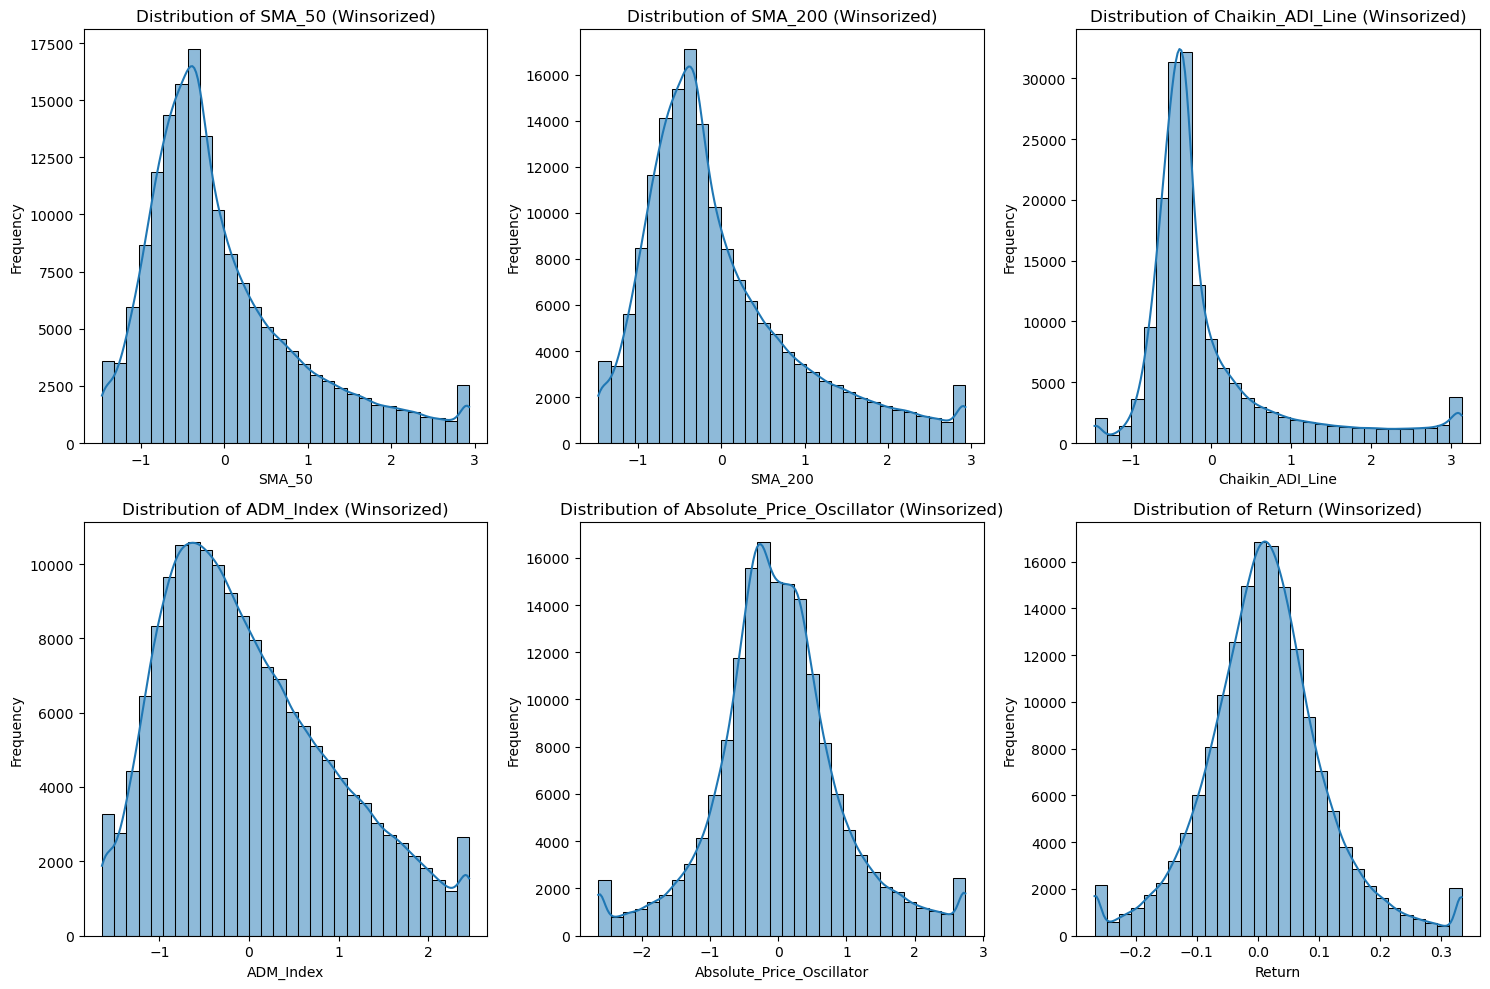

In [30]:
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns 

# Load the correct data file if available (Please upload the CSV if needed)
# Assuming all_data_df is already defined and loaded correctly

# Define factors to visualize
selected_factors = ["SMA_50", "SMA_200", "Chaikin_ADI_Line", "ADM_Index", "Absolute_Price_Oscillator", "Return"]

# Apply Winsorization (limit extreme percentiles)
df_winsorized = df_final.copy()
for factor in selected_factors:
    df_winsorized[factor] = winsorize(df_final[factor], limits=[0.01, 0.01])  # 1% Winsorization

# Plot new histograms with outlier handling
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, factor in enumerate(selected_factors):
    sns.histplot(df_winsorized[factor], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {factor} (Winsorized)")
    axes[i].set_xlabel(factor)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [37]:
all_data_df = df_final

In [54]:
# Split dataset
train_data = all_data_df[all_data_df.index < train_cutoff]
valid_data = all_data_df[(all_data_df.index >= train_cutoff) & (all_data_df.index < valid_cutoff)]
test_data = all_data_df[all_data_df.index >= valid_cutoff]

# Extract features and labels
def extract_features_labels(df):
    X = df.drop(columns=["Return", "Ranked_Return", "qid", "Ticker"]).values
    y = df["Ranked_Return"].values
    qid = df["qid"].values
    return X, y, qid

X_train, y_train, qid_train = extract_features_labels(train_data)
X_valid, y_valid, qid_valid = extract_features_labels(valid_data)
X_test, y_test, qid_test = extract_features_labels(test_data)

# Bootstrap sampling function
def bootstrap_sampling(X, y, qid, num_samples=10):
    N = X.shape[0]
    bootstrap_datasets = []
    for _ in range(num_samples):
        indices = np.random.choice(N, N, replace=True)  # Bootstrap sampling
        X_sample, y_sample, qid_sample = X[indices], y[indices], qid[indices]
        bootstrap_datasets.append((X_sample, y_sample, qid_sample))
    return bootstrap_datasets

# Generate bootstrap train sets
bootstrap_train_datasets = bootstrap_sampling(X_train, y_train, qid_train, num_samples=10)

# Save dataset
dataset = {
    "train": (X_train, y_train, qid_train),
    "bootstrap_train": bootstrap_train_datasets,
    "valid": (X_valid, y_valid, qid_valid),
    "test": (X_test, y_test, qid_test),
}

In [55]:
import xgboost as xgb
import numpy as np

models = []  # Store all trained XGBRanker models
valid_scores = []  # Store the best NDCG scores on the validation set

X_valid, y_valid, qid_valid = dataset["valid"]  # Load validation set data

# Iterate over bootstrap-sampled training data
for i, (X_sample, y_sample, qid_sample) in enumerate(dataset["bootstrap_train"]):
    print(f"Training model {i+1} ...")

    # Initialize XGBRanker
    model = xgb.XGBRanker(
        objective="rank:pairwise",
        n_estimators=500,  # Set a sufficiently large n_estimators, allowing early stopping to determine the best iteration
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        eval_metric="ndcg",  
        colsample_bytree=0.8,
        early_stopping_rounds=20
    )
    
    # Train the model and use the validation data for early stopping
    model.fit(
        X_sample, y_sample, 
        group=np.bincount(qid_sample),  # Training group information
        eval_set=[(X_valid, y_valid)],  # Provide validation set
        eval_group=[np.bincount(qid_valid)],  # Validation set group information
        verbose=True
    )

    # Store the model and validation score
    models.append(model)
    valid_scores.append(model.best_score)  # best_score: XGBoost automatically records the best NDCG value


Training model 1 ...
[0]	validation_0-ndcg:0.78633
[1]	validation_0-ndcg:0.79348
[2]	validation_0-ndcg:0.79867
[3]	validation_0-ndcg:0.79898
[4]	validation_0-ndcg:0.80627
[5]	validation_0-ndcg:0.80708
[6]	validation_0-ndcg:0.80876
[7]	validation_0-ndcg:0.81050
[8]	validation_0-ndcg:0.80776
[9]	validation_0-ndcg:0.81029
[10]	validation_0-ndcg:0.81130
[11]	validation_0-ndcg:0.81287
[12]	validation_0-ndcg:0.81047
[13]	validation_0-ndcg:0.81107
[14]	validation_0-ndcg:0.80888
[15]	validation_0-ndcg:0.80938
[16]	validation_0-ndcg:0.80983
[17]	validation_0-ndcg:0.81051
[18]	validation_0-ndcg:0.81066
[19]	validation_0-ndcg:0.81052
[20]	validation_0-ndcg:0.81083
[21]	validation_0-ndcg:0.80861
[22]	validation_0-ndcg:0.81013
[23]	validation_0-ndcg:0.81121
[24]	validation_0-ndcg:0.81140
[25]	validation_0-ndcg:0.81102
[26]	validation_0-ndcg:0.81236
[27]	validation_0-ndcg:0.81162
[28]	validation_0-ndcg:0.81240
[29]	validation_0-ndcg:0.81164
[30]	validation_0-ndcg:0.81230
[31]	validation_0-ndcg:0.812

In [56]:
import numpy as np
from sklearn.metrics import ndcg_score

# Load test dataset
X_test, y_test, qid_test = dataset["test"]

test_preds = np.zeros((len(models), len(X_test)))  # Store predictions from all models

# Iterate through all bootstrap-trained models
for i, model in enumerate(models):
    test_preds[i, :] = model.predict(X_test)

# Compute the final ensemble prediction (using the mean)
final_test_preds = np.mean(test_preds, axis=0) 

# Create a DataFrame to store predictions
predictions = pd.DataFrame({
    "qid": qid_test,
    "y_true": y_test,
    "y_pred": final_test_preds
}).sort_values(by="qid")


def compute_saber_scores(rank_lists):
    """
    Compute SABER ranking scores (combining rankings from multiple models).
    """
    mean_rank = np.mean(rank_lists, axis=0)  # Compute mean ranking across all models
    std_rank = np.std(rank_lists, axis=0)  # Compute ranking standard deviation
    saber_scores = 1 / (mean_rank * (std_rank + 1e-6))  # Avoid division by zero
    return saber_scores


In [57]:
import numpy as np
import pandas as pd
from sklearn.metrics import ndcg_score

# Load test dataset
X_test, y_test, qid_test = dataset["test"]

test_preds = np.zeros((len(models), len(X_test)))  # Store predictions from all models

# Iterate over all bootstrap-trained models
for i, model in enumerate(models):
    test_preds[i, :] = model.predict(X_test)  # Predictions from each model

# **Step 1: Compute rankings within each trading day (qid)**
rank_lists = np.zeros_like(test_preds)

for i in range(len(models)):  # Iterate over all models
    for qid in np.unique(qid_test):  # Iterate over all trading days
        mask = qid_test == qid  # Select data for the current trading day
        if np.sum(mask) > 1:  # Ensure there is data for the day
            rank_lists[i, mask] = np.argsort(np.argsort(-test_preds[i, mask]))  # Compute rankings within the day

# **Step 2: Compute SABER scores**
def compute_saber_scores(rank_lists):
    """
    Compute SABER long and short ranking scores.
    """
    mean_rank = np.mean(rank_lists, axis=0)  # Compute the average ranking across all models
    std_rank = np.std(rank_lists, axis=0)  # Compute the standard deviation of rankings
    
    saber_long = 1 / (mean_rank * (std_rank + 1e-6))  # Long strategy: higher and stable ranking
    saber_short = mean_rank / (std_rank + 1e-6)  # Short strategy: lower and stable ranking
    
    return saber_long, saber_short

saber_long, saber_short = compute_saber_scores(rank_lists)  # Compute long & short scores

# **Create a DataFrame to store final rankings**
predictions = pd.DataFrame({
    "qid": qid_test,  # Trading date
    "y_true": y_test,  # True ranking
    "saber_long": saber_long,  # Long strategy score
    "saber_short": saber_short  # Short strategy score
}).sort_values(by=["qid", "saber_long"], ascending=[True, False])  # Sort by day and descending long score

# **Step 4: Compute daily NDCG scores**
ndcg_long_scores = []
ndcg_short_scores = []

for qid in predictions["qid"].unique():
    daily_data = predictions[predictions["qid"] == qid]  # Select data for the day
    if len(daily_data) > 1:
        ndcg_long = ndcg_score([daily_data["y_true"].values], [daily_data["saber_long"].values])
        ndcg_short = ndcg_score([daily_data["y_true"].values], [-daily_data["saber_short"].values])  # Negative for short ranking
        ndcg_long_scores.append(ndcg_long)
        ndcg_short_scores.append(ndcg_short)

# Compute the average NDCG across all days
final_ndcg_long = np.mean(ndcg_long_scores)
final_ndcg_short = np.mean(ndcg_short_scores)

print(f"Ensemble SABER Long Strategy NDCG: {final_ndcg_long:.4f}")
print(f"Ensemble SABER Short Strategy NDCG: {final_ndcg_short:.4f}")


Ensemble SABER Long Strategy NDCG: 0.8854
Ensemble SABER Short Strategy NDCG: 0.8844


In [58]:
predictions

,qid,y_true,saber_long,saber_short
401,143,4,0.00822668,1.32688179
16,143,4,0.00678582,1.33001982
395,143,4,0.00495446,1.36524965
314,143,2,0.00469491,1.47086886
736,143,0,0.00378467,1.21264688
...,...,...,...,...
73477,227,2,0.00000615,2.19092379
73200,227,4,0.00000609,2.57182648
73717,227,2,0.00000603,2.11974520
73284,227,2,0.00000600,2.15789504


In [59]:
test_data_selected = test_data.reset_index()[["date", "qid", "Ticker", "Return"]]
predictions['return_true'] = test_data_selected['Return']
predictions["date"] = test_data_selected['date']

In [60]:
predictions

,qid,y_true,saber_long,saber_short,return_true,date
401,143,4,0.00822668,1.32688179,0.42708334,2018-01-31
16,143,4,0.00678582,1.33001982,0.00806452,2018-01-31
395,143,4,0.00495446,1.36524965,0.03896104,2018-01-31
314,143,2,0.00469491,1.47086886,-0.04612546,2018-01-31
736,143,0,0.00378467,1.21264688,-0.17123288,2018-01-31
...,...,...,...,...,...,...
73477,227,2,0.00000615,2.19092379,-0.03905435,2025-01-31
73200,227,4,0.00000609,2.57182648,0.05760651,2025-01-31
73717,227,2,0.00000603,2.11974520,-0.02764293,2025-01-31
73284,227,2,0.00000600,2.15789504,-0.03538066,2025-01-31


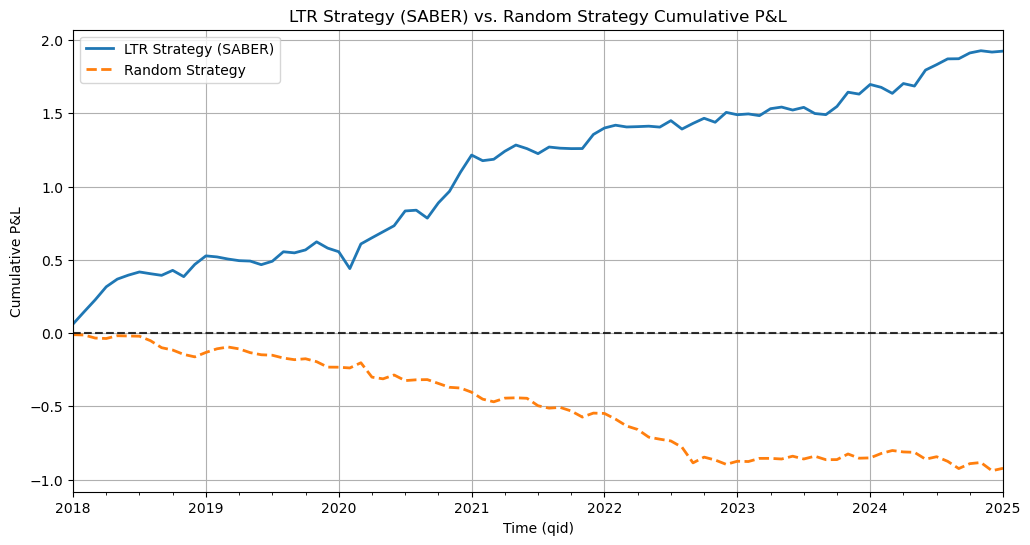

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set parameters
top_k = 10
position_size = 1 / (top_k * 2) 
risk_free_rate = 0.00

# Copy predictions DataFrame
df = predictions.copy()

# **Sort by `qid` (to maintain chronological order)**
df = df.sort_values(by=["qid"])

# **LTR Strategy**
# Step 1: Rank stocks within each `qid` based on SABER ranking
df["rank_long"] = df.groupby("qid")["saber_long"].rank(ascending=False, method="first")  # Rank for long positions (descending)
df["rank_short"] = df.groupby("qid")["saber_short"].rank(ascending=False, method="first")  # Rank for short positions (descending)

# Step 2: Select long and short positions based on SABER ranking
df["long"] = (df["rank_long"] <= top_k).astype(int)  # Select long positions
df["short"] = (df["rank_short"] <= top_k).astype(int)  # Select short positions

# Step 3: Compute returns for long and short positions
df["long_return"] = df["long"] * df["return_true"]
df["short_return"] = -df["short"] * df["return_true"]  # Short positions have negative returns

# Step 4: Compute daily strategy returns
df["ltr_strategy_return"] = position_size * (df["long_return"] + df["short_return"])

# **Random Strategy**
df["random_long"] = df.groupby("qid")["saber_long"].transform(
    lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)]))
df["random_short"] = df.groupby("qid")["saber_short"].transform(
    lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)]))

df["random_long_return"] = df["random_long"] * df["return_true"]
df["random_short_return"] = -df["random_short"] * df["return_true"]

df["random_strategy_return"] = position_size * (df["random_long_return"] + df["random_short_return"])

# **Compute cumulative returns**
monthly_pnl_ltr = df.groupby("date")["ltr_strategy_return"].sum()
monthly_pnl_random = df.groupby("date")["random_strategy_return"].sum()

cumulative_pnl_ltr = monthly_pnl_ltr.cumsum()
cumulative_pnl_random = monthly_pnl_random.cumsum()

# **Compute performance metrics**
def compute_metrics(monthly_pnl, label):
    mean_return = monthly_pnl.mean() * 12  # Annualized return
    std_dev = monthly_pnl.std() * np.sqrt(12)  # Annualized volatility
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan
    return {
        "Strategy": label,
        "Annualized Return": mean_return,
        "Annualized Volatility": std_dev,
        "Sharpe Ratio": sharpe_ratio
    }

ltr_metrics = compute_metrics(monthly_pnl_ltr, "LTR Strategy (SABER)")
random_metrics = compute_metrics(monthly_pnl_random, "Random Strategy")

performance_df = pd.DataFrame([ltr_metrics, random_metrics])

# **Plot cumulative returns**
plt.figure(figsize=(12, 6))
cumulative_pnl_ltr.plot(label="LTR Strategy (SABER)", linewidth=2)
cumulative_pnl_random.plot(label="Random Strategy", linewidth=2, linestyle="dashed")

plt.axhline(y=0, color="black", linestyle="--", alpha=0.8)
plt.xlabel("Time (qid)")
plt.ylabel("Cumulative P&L")
plt.title("LTR Strategy (SABER) vs. Random Strategy Cumulative P&L")
plt.legend()
plt.grid()
plt.show()


In [63]:
df["prev_long"] = df.groupby("qid")["long"].shift(1).fillna(0)  # Previous period (last month) long positions
df["prev_short"] = df.groupby("qid")["short"].shift(1).fillna(0)  # Previous period (last month) short positions

# **Step 1: Compute previous total holdings**
df["prev_total_holdings"] = df["prev_long"] + df["prev_short"]  # Total positions in the previous period

# **Step 2: Compute absolute position changes**
df["turnover_ltr_abs"] = ((df["long"] - df["prev_long"]).abs() + (df["short"] - df["prev_short"]).abs())/2

# **Step 3: Compute monthly turnover**
monthly_turnover_ltr = df.groupby("date")[["turnover_ltr_abs", "prev_total_holdings"]].sum()  # Sum across all stocks
monthly_turnover_ltr["turnover_rate"] = np.where(monthly_turnover_ltr["prev_total_holdings"] > 0,
                                                 monthly_turnover_ltr["turnover_ltr_abs"] / monthly_turnover_ltr["prev_total_holdings"],
                                                 0)  # Avoid division by zero

# **Step 4: Compute the average monthly turnover rate**
avg_turnover_ltr = monthly_turnover_ltr["turnover_rate"].mean()

df["prev_random_long"] = df.groupby("qid")["random_long"].shift(1).fillna(0)  # Previous period (last month) long positions
df["prev_random_short"] = df.groupby("qid")["random_short"].shift(1).fillna(0)  # Previous period (last month) short positions

# **Repeat for random strategy**
df["prev_total_holdings_random"] = df["prev_random_long"] + df["prev_random_short"]
df["turnover_random_abs"] = ((df["random_long"] - df["prev_random_long"]).abs() + (df["random_short"] - df["prev_random_short"]).abs())/2

monthly_turnover_random = df.groupby("date")[["turnover_random_abs", "prev_total_holdings_random"]].sum()
monthly_turnover_random["turnover_rate"] = np.where(monthly_turnover_random["prev_total_holdings_random"] > 0,
                                                    monthly_turnover_random["turnover_random_abs"] / monthly_turnover_random["prev_total_holdings_random"],
                                                    0)

avg_turnover_random = monthly_turnover_random["turnover_rate"].mean()


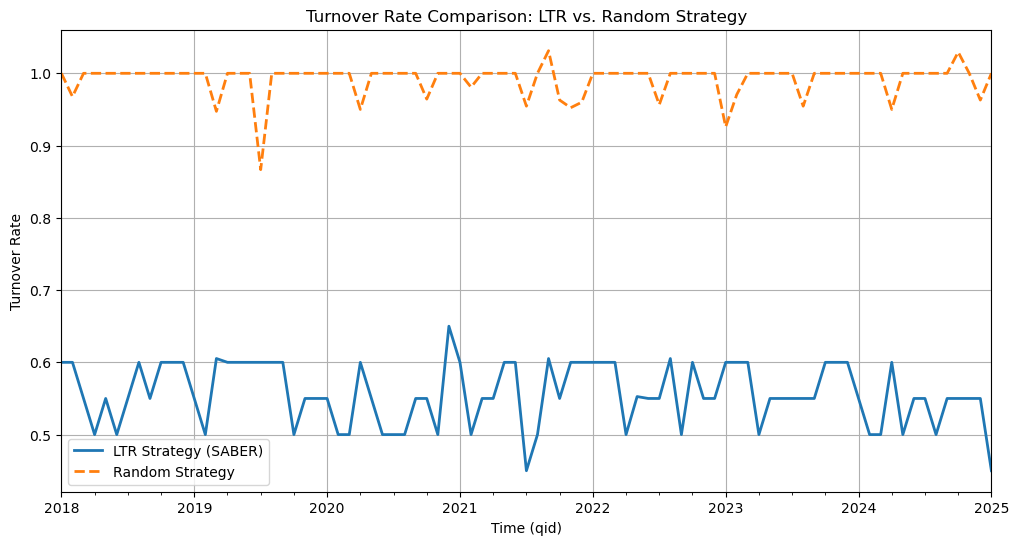

In [64]:
# **Plot turnover rate over time**
plt.figure(figsize=(12, 6))
monthly_turnover_ltr["turnover_rate"].plot(label="LTR Strategy (SABER)", linewidth=2)
monthly_turnover_random["turnover_rate"].plot(label="Random Strategy", linewidth=2, linestyle="dashed")

plt.xlabel("Time (qid)")
plt.ylabel("Turnover Rate")
plt.title("Turnover Rate Comparison: LTR vs. Random Strategy")
plt.legend()
plt.grid()
plt.show()

In [65]:
performance_df

,Strategy,Annualized Return,Annualized Volatility,Sharpe Ratio
0,LTR Strategy (SABER),0.27162752,0.16902705,1.60700620
1,Random Strategy,-0.13025166,0.09669125,-1.34708848
